# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-0x85zff7
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-0x85zff7
  Resolved https://github.com/greydanus/mnist1d to commit 68cb6b2d1d3a956cc2e9035e5a9860b66e33d642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post15-py3-none-any.whl size=14561 sha256=3e79eaab27c71ea9d6e7c6380ded29a1c7143236a7053d75e929d51c62ee6eba
  Stored in directory: /tmp/pip-ephem-wheel-cache-vailb4dz/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [15]:
# Define dimensions
D_i = 40    # Input dimensions
D_h1 = 150  # Hidden layer 1 dimensions
D_h2 = 150  # Hidden layer 2 dimensions
D_o = 10    # Output dimensions

# Replace this line (see Figure 7.8 of book for help):
model = nn.Sequential(
    nn.Linear(D_i, D_h1),
    nn.ReLU(),
    nn.Linear(D_h1, D_h2),
    nn.ReLU(),
    nn.Linear(D_h2, D_o)
)

# Function to initialize weights with He initialization
def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        torch.nn.init.kaiming_normal_(layer_in.weight)


# Call the function you just defined
model.apply(weights_init)


Sequential(
  (0): Linear(in_features=40, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=150, bias=True)
  (3): ReLU()
  (4): Linear(in_features=150, out_features=10, bias=True)
)

In [16]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.95)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.704752, train error 65.38,  test loss 1.773797, test error 70.20
Epoch     1, train loss 1.493585, train error 56.47,  test loss 1.612397, test error 63.00
Epoch     2, train loss 1.321903, train error 47.97,  test loss 1.471122, test error 55.10
Epoch     3, train loss 1.199575, train error 43.20,  test loss 1.390658, test error 51.80
Epoch     4, train loss 1.076569, train error 36.83,  test loss 1.305547, test error 50.80
Epoch     5, train loss 0.988885, train error 33.62,  test loss 1.256415, test error 49.40
Epoch     6, train loss 0.909597, train error 30.28,  test loss 1.226843, test error 47.80
Epoch     7, train loss 0.849688, train error 28.25,  test loss 1.204921, test error 48.40
Epoch     8, train loss 0.784354, train error 25.28,  test loss 1.201031, test error 46.80
Epoch     9, train loss 0.713434, train error 22.38,  test loss 1.151345, test error 44.90
Epoch    10, train loss 0.682116, train error 21.18,  test loss 1.138110, test error 43.80

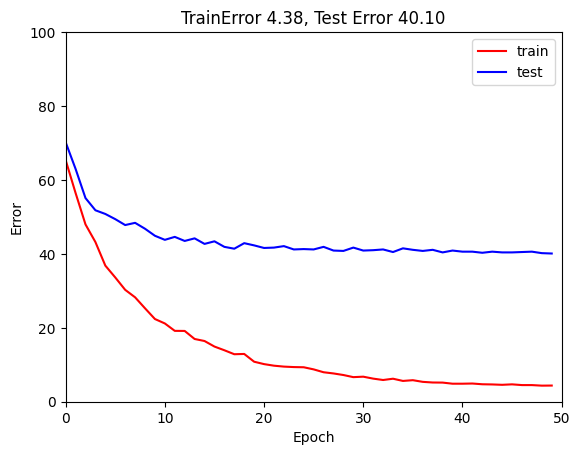

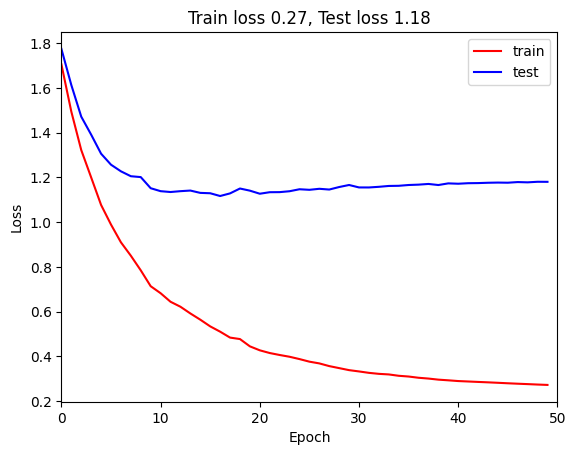

In [17]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

I increased the number of layers from 1 to 2, which increases the model's capacity to learn more complex patterns in the data. Each hidden layer learns different features, allowing the model to better represent the underlying structure of the data.

I increased the hidden units from 100 to 150 per layer, which provides more computational power to the model. Each unit in the hidden layer learns a different feature from input data. This allows the network to store more information about the training data, leading to better representation of the data and reduce underfitting.

I lowered the learning rate from 0.05 to 0.01. This ensures the model converges more smoothly and doesn't overshoot the optimal parameters during training.

I increased the momentum from 0.09 to 0.95, which helps smooth out updates during training, preventing the model from scillating between poor solutions. This leads to better generalization during the test set.

Together, these changes can increase the model's ability to generalize well to new data, leading to improve test accuracy and overall performance.

However, attempting to optimize the parameters in this way may not result in an accurate estimate of the model's true performance. Manually adjusting the hyperparameters in such a way can lead to biased results. Good practice would be to used a structure approach like a random search to systemically explore hyperparameters.